# Robust Bench and Auto Attack

In [1]:
import xlab # for testing your code

from robustbench.utils import load_model
from robustbench.data import load_cifar10
import torch
from torch import nn
import matplotlib.pyplot as plt
from autoattack import AutoAttack
import torchattacks
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

We will begin by loading a pretrained model for classification on CIFAR using robustbench.

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


Next let's look at the architecture. We can see that this is the Wide ResNet we discussed earlier in this course. We encourage you to take a look that the model strucutre to see if you can infer what is going on.

## Task 1: Benchmark WideResNet on Clean Images

Now let's see how robust this base model is. First we will want to benchmark the accuracy of clean images. For compuational efficency, we will only load 100 images from [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). If you would like to load more, and you computer can handle it, we encourage you to do so!

In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [5]:
def benchmark_wideresnet(model, imgs, labels):
    '''return the accuracy of the model as a floating point number between 0.0 and 1.0'''
    acc = 0

    logits = model(imgs)
    pred_labels = torch.argmax(logits, dim=1)
    num_correct = torch.sum(pred_labels == labels)
    total_imgs = len(labels)
    acc = num_correct/total_imgs
    
    return acc.item()

acc = benchmark_wideresnet(model, x_test, y_test)
print(f"Model accuracy is {acc*100:.2f}% for clean images")

Model accuracy is 94.00% for clean images


In [6]:
# This test will make sure you have reasonable accuracy for the first 100 testing images.
# Do NOT change the function below: you do not need to pass in any images or labels.
_ = xlab.tests.section2_4_2.task1(benchmark_wideresnet, model)

Running tests for Section 2.4.2, Task 1...

Using device: mps:0 for testing...
✓ 1. Test case model accuracy > 90%                            PASSED
     Accuracy: 0.9400
✓ 2. Test case student function returns correct accuracy       PASSED
     Expected: 0.9400 (±0.01)
     Got:      0.9400
     Difference: 0.0000

🎉 All tests passed! (2/2)


## Targeted Attack on Model

To show how vunerable this pretrained model is to adversarial attacks, we will benchmark it on a PGD attack with only 20 total steps.

In [7]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
itos = {i: s for i, s in enumerate(classes)}
stoi = {s: i for i, s in itos.items()}

In [8]:
# we are loading a targeted attack with only 20 total steps
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=20)
pgd.set_mode_targeted_by_label(quiet=True)

As a refresher, the code below will run a targeted attack against the model. In the one example below, we take an image of a horse and run PGD to generate an example that fools the model into thinking it is a frog.

In [9]:
img_idx = 13 # this is an image of a horse
true_class_idx = y_test[img_idx].item()
target_class = 'frog'

print(f'Running PGD to misclasify {itos[true_class_idx]} as {target_class}...')

adv_images = pgd(x_test[img_idx:img_idx+1], torch.tensor([stoi[target_class]]))

model_adv_pred = torch.argmax(model(adv_images)).item()
model_clean_pred = torch.argmax(model(x_test[img_idx:img_idx+1].to('mps'))).item()

print(f"Clean Predicted Label = '{itos[model_clean_pred]}', Adversarial Predicted Label = '{itos[model_adv_pred]}'")

Running PGD to misclasify horse as frog...
Clean Predicted Label = 'horse', Adversarial Predicted Label = 'frog'


## Task 2: Benchmark on Targeted PGD Attacks

In [10]:
def get_targeted_pgd_imgs(model, img, targets, steps, epsilon):
    '''
    model: WideResNet
    img: torch.tensor of size torch.Size([batch, 3, 32, 32])
    targets: torch.tensor of size torch.Size([batch])
    steps: int
    epsilson: float
    '''
    pgd = torchattacks.PGD(model, eps=epsilon, alpha=2/255, steps=steps)
    pgd.set_mode_targeted_by_label(quiet=True)
    
    adv_img = pgd(img, targets)

    return adv_img 

In [12]:
_ = xlab.tests.section2_4_2.task2(get_targeted_pgd_imgs, model)

Running tests for Section 2.4.2, Task 2...

Using device: mps:0 for testing...
✓ 1. Test case model accuracy > 90%                            PASSED
     Accuracy: 0.9400
✓ 2. Test case adversarial attack succeeds                     PASSED
     Target class: 9
     Predicted class: 9
     Adversarial attack successfully fooled the model

🎉 All tests passed! (2/2)


In [35]:
x_test[1].shape

torch.Size([3, 32, 32])

In [36]:
y_test.shape

torch.Size([100])

In [42]:
a = get_targeted_pgd_imgs(model, x_test[1:2], torch.tensor([9]), 20, 8/255)

In [43]:
torch.argmax(model(a))

tensor(9, device='mps:0')

In [44]:
y_test[1]

tensor(8, device='mps:0')

## Demonstrating the Failures of Benchmarks



<blockquote>
    <i>Another cause of poor evaluations is the lack of diversity among the attacks used, as most papers rely solely
    on the results given by PGD or weaker versions of it like
    FGSM.
    </i>
</blockquote>

To be very clear: <b>We do not present the below defense because it is good.</b> We present it because it will <i>appear</i> good
under a poorly designed evaluation.

In [72]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): WiggleReLU()
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): WiggleReLU()
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): WiggleReLU()
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05

In [8]:
model = model.to('mps')

In [10]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:5], y_test[:5])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 100.00%
apgd-ce - 1/1 - 5 out of 5 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 9.5 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


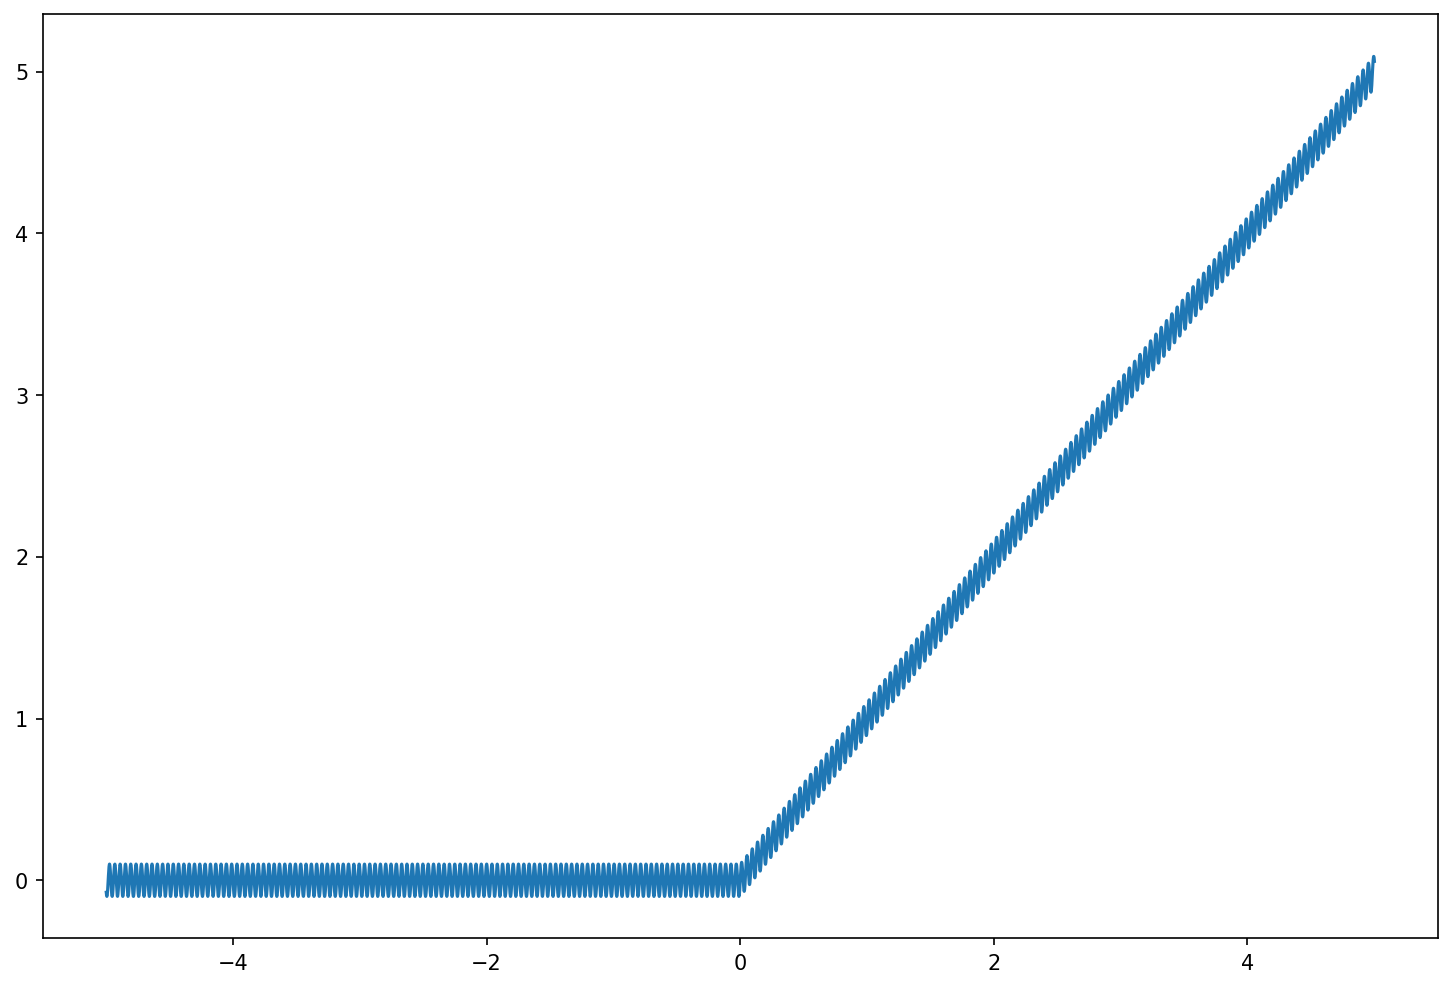

In [54]:
import torch
from torch import nn
import matplotlib.pyplot as plt

def wiggle_relu(x):
    return nn.functional.relu(x) + 0.1*torch.sin(150 * x)

x = torch.arange(-5, 5.001, 0.001)
y = wiggle_relu(x)

plt.figure(figsize=(12, 8), dpi=150)  # High resolution with larger size
plt.plot(x.numpy(), y.numpy())
plt.show()

In [64]:
model

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [67]:
class WiggleReLU(nn.Module):
    def __init__(self):
        super(WiggleReLU, self).__init__()
    
    def forward(self, x):
        return nn.functional.relu(x) + 0.1*torch.sin(100000 * x)

model.block1.layer[0].relu2 = WiggleReLU()
model.block1.layer[0].relu1 = WiggleReLU()
model.block1.layer[1].relu2 = WiggleReLU()
model.block1.layer[1].relu1 = WiggleReLU()
model.block1.layer[2].relu2 = WiggleReLU()
model.block1.layer[2].relu1 = WiggleReLU()
model.block1.layer[3].relu2 = WiggleReLU()
model.block1.layer[3].relu1 = WiggleReLU()

model.block2.layer[0].relu2 = WiggleReLU()
model.block2.layer[0].relu1 = WiggleReLU()
model.block2.layer[1].relu2 = WiggleReLU()
model.block2.layer[1].relu1 = WiggleReLU()
model.block2.layer[2].relu2 = WiggleReLU()
model.block2.layer[2].relu1 = WiggleReLU()
model.block2.layer[3].relu2 = WiggleReLU()
model.block2.layer[3].relu1 = WiggleReLU()

model.block3.layer[0].relu2 = WiggleReLU()
model.block3.layer[0].relu1 = WiggleReLU()
model.block3.layer[1].relu2 = WiggleReLU()
model.block3.layer[1].relu1 = WiggleReLU()
model.block3.layer[2].relu2 = WiggleReLU()
model.block3.layer[2].relu1 = WiggleReLU()
model.block3.layer[3].relu2 = WiggleReLU()
model.block3.layer[3].relu1 = WiggleReLU()

In [70]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:100], y_test[:100])

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 96.00%
apgd-ce - 1/1 - 5 out of 48 successfully perturbed
robust accuracy after APGD-CE: 86.00% (total time 79.4 s)
apgd-dlr - 1/1 - 1 out of 43 successfully perturbed
robust accuracy after APGD-DLR: 84.00% (total time 153.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 84.00%


In [71]:
from autoattack import AutoAttack

adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr', 'square'], device ='mps')
adversary.apgd.n_restarts = 1
x_adv = adversary.run_standard_evaluation(x_test[:100], y_test[:100])

using custom version including apgd-ce, apgd-dlr, square.
initial accuracy: 96.00%
apgd-ce - 1/1 - 3 out of 48 successfully perturbed
robust accuracy after APGD-CE: 90.00% (total time 77.5 s)
apgd-dlr - 1/1 - 3 out of 45 successfully perturbed
robust accuracy after APGD-DLR: 84.00% (total time 152.0 s)
square - 1/1 - 32 out of 42 successfully perturbed
robust accuracy after SQUARE: 20.00% (total time 713.9 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 20.00%


In [5]:
from robustbench.data import load_cifar10
x_test, y_test = load_cifar10(n_examples=50) # load CIFAR 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:07<00:00, 22.3MB/s]
